# Deadzone EMS

Functionality tests for Deadzone EMS

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import sawtooth

from hessems import deadzone

%matplotlib widget

## Deadzone Function

(Singular saturated deadzone function without SOC Feedback Logic)

- Parameters: `slope_pos, slope_neg, out_max, out_min, threshold_neg`
- Input: `val_in, para`
- Output: `base, peak`

### Slope = const., vary out min/max and threshold (pos, neg)

Text(0.5, 0.98, 'Cols: threshold (neg, pos)  |  Rows: saturation (min, max)')

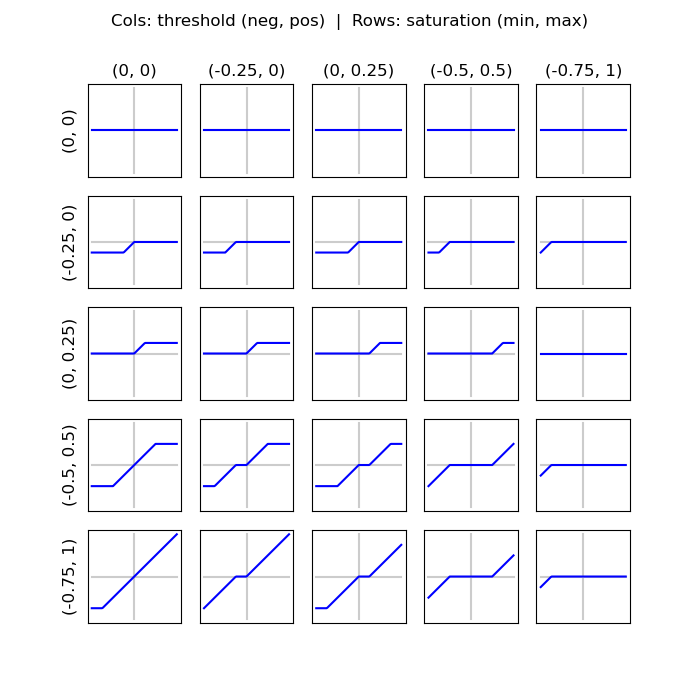

In [3]:
t_tup = ((0, 0), (-0.25, 0), (0, 0.25), (-0.5, 0.5), (-0.75, 1))
o_tup = t_tup

x = np.linspace(-1, 1, 101)

fig, axs = plt.subplots(5, 5, figsize=(7, 7))

for row, (on, op) in enumerate(o_tup):
    for col, (tn, tp) in enumerate(t_tup):
        para = {
            'slope_pos': 1,
            'slope_neg': 1,
            'threshold_pos': tp,
            'threshold_neg': tn,
            'out_max': op,
            'out_min': on,
        }
        y = deadzone._sat_deadzone(x, para)
        axs[row, col].plot([-1, 1], [0, 0], '0.8')
        axs[row, col].plot([0, 0], [-1, 1], '0.8')
        axs[row, col].plot(x, y, 'blue')
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])

for col, tup in enumerate(t_tup):
    axs[0, col].set_title(tup)
for row, tup in enumerate(o_tup):
    axs[row, 0].set_ylabel(tup, size='large')
fig.suptitle(f'Cols: threshold (neg, pos)  |  Rows: saturation (min, max)')


### Different slopes; Threshold and Saturation const.

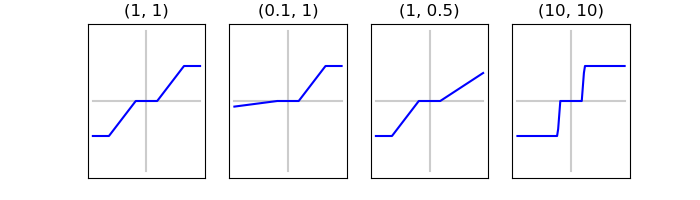

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(7,2))
para = {
    'slope_pos': 1,
    'slope_neg': 1,
    'threshold_pos': 0.2,
    'threshold_neg': -0.2,
    'out_max': 0.5,
    'out_min': -0.5,
}
x = np.linspace(-1, 1, 101)
svals = ((1, 1), (0.1, 1), (1, 0.5), (10, 10))
for (sn, sp), ax in zip(svals, axs):
    para['slope_neg'] = sn
    para['slope_pos'] = sp
    y = deadzone._sat_deadzone(x, para)
    ax.plot([-1, 1], [0, 0], '0.8')
    ax.plot([0, 0], [-1, 1], '0.8')
    ax.plot(x, y, 'blue')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{(sn, sp)}')

## Feedback Function

Test Feedback logic, sweep `energy reference` input in `[0, 1]`

- Parameters: `window_up, window_low, gain`
- Input: `eref`
- Output: `feedback_val`

Test different windows, different gains

Text(0.5, 0.98, 'Cols: Windows  |  Rows: Gains')

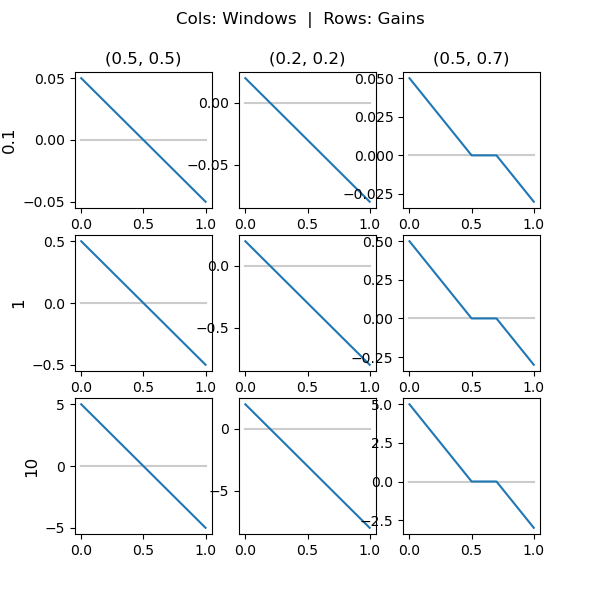

In [5]:
x = np.linspace(0, 1, 101)
windows = ((0.5, 0.5), (0.2, 0.2), (0.5, 0.7))
gains = (0.1, 1, 10)
fig, axs = plt.subplots(3, 3, figsize = (6, 6))
for col, (wlow, wup) in enumerate(windows):
    for row, gain in enumerate(gains):
        para = {
            'gain': gain,
            'window_up': wup,
            'window_low': wlow,
        }
        y = deadzone._feedback(x, para)
        axs[row, col].plot([0, 1], [0, 0], '0.8')
        axs[row, col].plot(x, y)

for col, w in enumerate(windows):
    axs[0, col].set_title(w)
for row, g in enumerate(gains):
    axs[row, 0].set_ylabel(g, size='large')
fig.suptitle('Cols: Windows  |  Rows: Gains')

## Reserve Calculation Function

- Parameters: `base_min, base_max, peak_min, peak_max`
- Input: `base, peak`
- Output: `reserve_low, reserve_high`

---

- Test different ratios of base min/max, peak min/max (cols)
- Dim 1: test different base inputs, sweep peak (rows)
- Dim 2: test different peak inputs, sweep base (rows)

Text(0.5, 0.98, 'Cols: Power Caps (bmin, bmax, pmin, pmax)  |  Rows: Relative baseval')

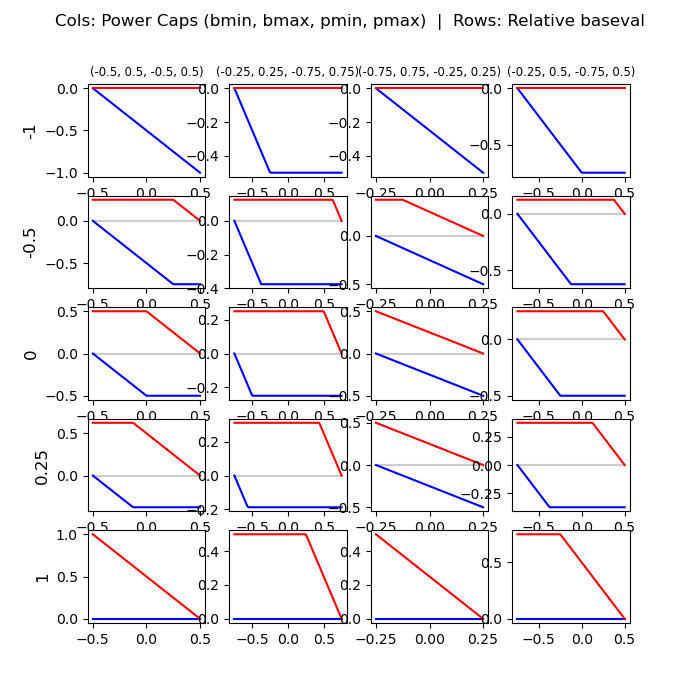

In [6]:
# base_min, base_max, peak_min, peak_max
powers = ((-0.5, 0.5, -0.5, 0.5),
          (-0.25, 0.25, -0.75, 0.75),
          (-0.75, 0.75, -0.25, 0.25),
          (-0.25, 0.5, -0.75, 0.5))
const_vals = (-1, -0.5, 0, 0.25, 1)

fig, axs = plt.subplots(5, 4, figsize=(7, 7))

for row, cv in enumerate(const_vals):
    for col, (bmin, bmax, pmin, pmax) in enumerate(powers):
        para = {
            'base_min': bmin,
            'base_max': bmax,
            'peak_min': pmin,
            'peak_max': pmax,
        }
        base = -cv*bmin if cv < 0 else cv*bmax
        peak = np.linspace(pmin, pmax, 101)

        rlow, rhigh = deadzone._reserve(base, peak, para)
        axs[row, col].plot([peak[0], peak[-1]], [0, 0], '0.8')
        axs[row, col].plot(peak, rlow, 'blue')
        axs[row, col].plot(peak, rhigh, 'red')

for col, tup in enumerate(powers):
    axs[0, col].set_title(tup, size='small')
for row, tup in enumerate(const_vals):
    axs[row, 0].set_ylabel(tup, size='large')
fig.suptitle(f'Cols: Power Caps (bmin, bmax, pmin, pmax)  |  '
             f'Rows: Relative baseval')


Text(0.5, 0.98, 'Cols: Power Caps (bmin, bmax, pmin, pmax)  |  Rows: Relative peakval')

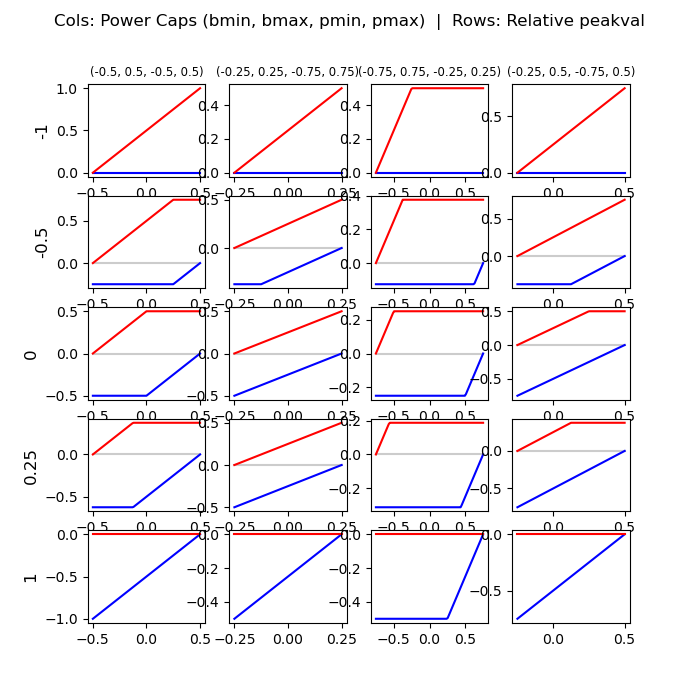

In [7]:
# base_min, base_max, peak_min, peak_max
powers = ((-0.5, 0.5, -0.5, 0.5),
          (-0.25, 0.25, -0.75, 0.75),
          (-0.75, 0.75, -0.25, 0.25),
          (-0.25, 0.5, -0.75, 0.5))
const_vals = (-1, -0.5, 0, 0.25, 1)

fig, axs = plt.subplots(5, 4, figsize=(7, 7))

for row, cv in enumerate(const_vals):
    for col, (bmin, bmax, pmin, pmax) in enumerate(powers):
        para = {
            'base_min': bmin,
            'base_max': bmax,
            'peak_min': pmin,
            'peak_max': pmax,
        }
        peak = -cv*pmin if cv < 0 else cv*pmax
        base = np.linspace(bmin, bmax, 101)

        rlow, rhigh = deadzone._reserve(base, peak, para)
        axs[row, col].plot([base[0], base[-1]], [0, 0], '0.8')
        axs[row, col].plot(base, rlow, 'blue')
        axs[row, col].plot(base, rhigh, 'red')

for col, tup in enumerate(powers):
    axs[0, col].set_title(tup, size='small')
for row, tup in enumerate(const_vals):
    axs[row, 0].set_ylabel(tup, size='large')
fig.suptitle(f'Cols: Power Caps (bmin, bmax, pmin, pmax)  |  '
             f'Rows: Relative peakval')


## Complete tests

### Feedback = 0, triangle waves

- Different threshold values, different priotizations
- columns: `base/peak = [0.25/0.75, 0.5/0.5, 0.75/0.25]`
- rows: `base prio, peak prio, base-discharge-peak-charge`

Text(0.5, 0.98, 'Cols: Power Caps (bmax, pmax)  |  Rows: threshold values ((-1, 1), (0, 0), (-1, 0))')

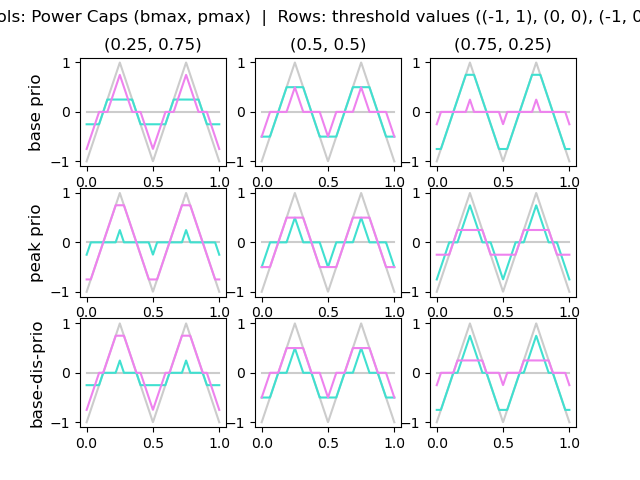

In [8]:
# Triangle Wave
x = np.linspace(0, 1, 1000)
y = sawtooth(2*x*2*np.pi, width=0.5)
ratios = ((0.25, 0.75), (0.5, 0.5), (0.75, 0.25))
thresholds = ((-1, 1), (0, 0), (-1, 0))


fig, axs = plt.subplots(3, 3)
for col, (bcap, pcap) in enumerate(ratios):
    for row, (tn, tp) in enumerate(thresholds):
        para = {
            'slope_pos': 1,
            'slope_neg': 1,
            'out_max': pcap,
            'out_min': -pcap,
            'threshold_pos': tp*bcap,
            'threshold_neg': tn*bcap,
            'gain': 0.0,
            'window_up': 0.5,
            'window_low': 0.5,
            'base_max': bcap,
            'peak_max': pcap,
            'base_min': -bcap,
            'peak_min': -pcap
        }
        base, peak = deadzone.deadzone(y, np.linspace(0, 1, len(y)), para)
        axs[row, col].plot([0, 1], [0, 0], '0.8')
        axs[row, col].plot(x, y, '0.8')
        axs[row, col].plot(x, base, 'turquoise')
        axs[row, col].plot(x, peak, 'violet')

for col, tup in enumerate(ratios):
    axs[0, col].set_title(tup)
for row, tup in enumerate(['base prio', 'peak prio', 'base-dis-prio']):
    axs[row, 0].set_ylabel(tup, size='large')
fig.suptitle(f'Cols: Power Caps (bmax, pmax)  |  '
             f'Rows: threshold values {thresholds}')

### Feedback sweep 0...1, window [0.4, 0.6], k=0.1

Text(0.5, 0.98, 'Cols: val_in value  |  Rows: prio + ratios ((0.25, 0.75), (0.5, 0.5), (0.75, 0.25))')

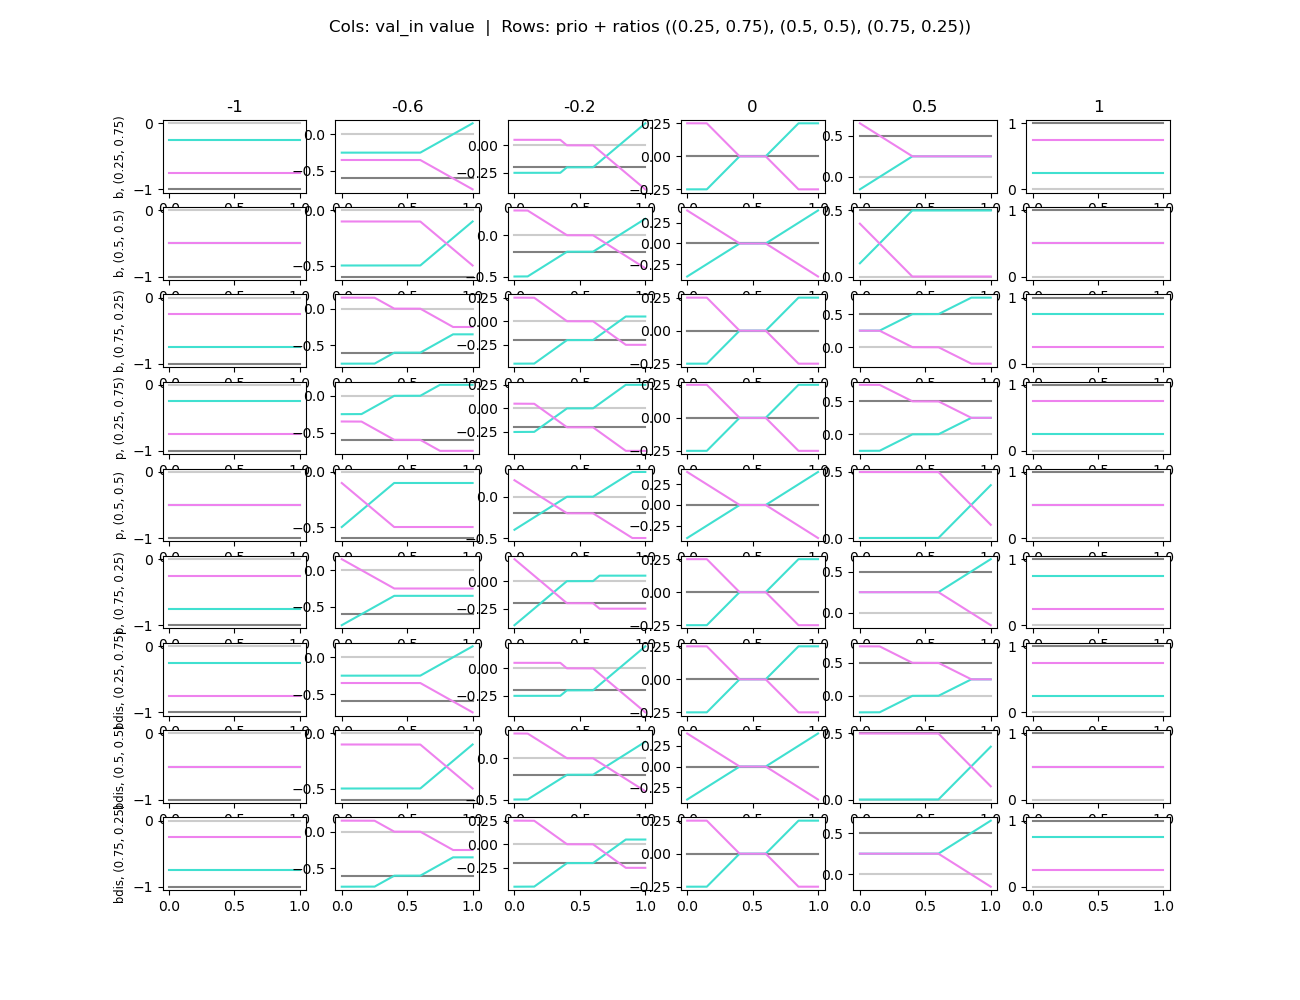

In [9]:
# E ref sweep
x = np.linspace(0, 1, 1000)
y = x
steps = (-1, -0.6, -0.2, 0, 0.5, 1)
ratios = ((0.25, 0.75), (0.5, 0.5), (0.75, 0.25))
thresholds = ((-1, 1), (0, 0), (-1, 0))

fig, axs = plt.subplots(9, 6, figsize=(13, 10))
for row_sup, (tn, tp) in enumerate(thresholds):
    for row_sub, (bcap, pcap) in enumerate(ratios):
        for col, step in enumerate(steps):
            row = 3*row_sup + row_sub
            para = {
                'slope_pos': 1,
                'slope_neg': 1,
                'out_max': pcap,
                'out_min': -pcap,
                'threshold_pos': tp*bcap,
                'threshold_neg': tn*bcap,
                'gain': 1,
                'window_up': 0.6,
                'window_low': 0.4,
                'base_max': bcap,
                'peak_max': pcap,
                'base_min': -bcap,
                'peak_min': -pcap
            }
            eref = y
            base, peak = deadzone.deadzone(step, eref, para)
            axs[row, col].plot([0, 1], [0, 0], '0.8')
            axs[row, col].plot([0, 1], [step, step], '0.5')
            axs[row, col].plot(x, base, 'turquoise')
            axs[row, col].plot(x, peak, 'violet')

for col, tup in enumerate(steps):
    axs[0, col].set_title(tup)
rowtags = [f'{prio}, {r}'
           for prio in ['b', 'p', 'bdis']
           for r in ratios]
for row, tup in enumerate(rowtags):
    axs[row, 0].set_ylabel(tup, size='small')
fig.suptitle(f'Cols: val_in value  |  '
             f'Rows: prio + ratios {ratios}')